## Análise de Eficácia de Intervenções - Da. Francisca na rotatória do Tecelão

Descrição do Relatório

7 a 15 de Março - Intervenção Tecelão, fizeram uma segunda pista na Marquês de Olinda sentido Norte.
Checar se houve aumento de fila na Rua Dona Francisca.

Insira abaixo os parâmetros do relatório e selecione "Cell" -> "Run All" para gerar os relatórios. Estarão armazenados no S3 da Amazon.

In [1]:
nome_arquivos = "Da.FranciscaTecelao"

dia_inicio_intervencao = 7
mes_inicio_intervencao = 3
ano_inicio_intervencao = 2018

dia_fim_intervencao = 15
mes_fim_intervencao = 3
ano_fim_intervencao = 2018

#Dias antes e depois da data de intervenção para análise de indicadores
periodo_analise = 21

horarios = [7,8,17,18]
fins_de_semana = False

#Lista de pares de coordenadas (Latitude,Longitude) !NESTA ORDEM! que identificam os trechos a serem avaliados
lista_coordenadas = [
    (-26.26424, -48.86134, "Norte", "Dn. Fcisca Norte antes rotatória."),
    (-26.26436, -48.86171, "Norte", "Marquês Olinda Norte antes rotatória"),
]

In [2]:
%matplotlib inline
import os
import sys
project_dir = os.path.join(os.pardir, os.pardir)
sys.path.append(project_dir)

import dotenv
dotenv_path = os.path.join(project_dir, '.env')
dotenv.load_dotenv(dotenv_path)

from IPython.display import display
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime
from shapely.geometry import LineString, Point
from shapely.wkt import loads as wkt_loads
import boto3
import io

import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use("seaborn-darkgrid")

from src.data import processing_func

import importlib
pd.options.display.max_columns = 30
pd.options.display.max_rows = 200

In [3]:
#Connection and initial setup
DATABASE = {
'drivername': os.environ.get("db_drivername"),
'host': os.environ.get("db_host"), 
'port': os.environ.get("db_port"),
'username': os.environ.get("db_username"),
'password': os.environ.get("db_password"),
'database': os.environ.get("db_database"),
}

importlib.reload(processing_func)

meta = processing_func.connect_database(DATABASE)

intervention_date_begin = datetime.date(day=dia_inicio_intervencao,
                                        month=mes_inicio_intervencao,
                                        year=ano_inicio_intervencao)
intervention_date_end = datetime.date(day=dia_fim_intervencao,
                                        month=mes_fim_intervencao,
                                        year=ano_fim_intervencao)

date_begin = intervention_date_begin - datetime.timedelta(days=periodo_analise)

date_end = intervention_date_end + datetime.timedelta(days=periodo_analise)

df_jams = processing_func.extract_df_jams(meta, date_begin, date_end, weekends=fins_de_semana)
print("Dado cru tem shape:")
display(df_jams.shape)

#Enrich and transform df_jams to geo_jams
importlib.reload(processing_func)
geo_jams = processing_func.transform_geo_jams(df_jams)
print("Dados transformados tem formato:")
display(geo_jams.shape)

#Connect to S3
s3 = boto3.client('s3',
                  aws_access_key_id=os.environ.get("aws_access_key"),
                  aws_secret_access_key=os.environ.get("aws_secret_key"))

# Filter holidays from list of holidays in Brazil, from ANBIMA
bucket = "smartmob-data"
key = "external/feriados_nacionais.xls"
result_dict = s3.get_object(Bucket=bucket, Key=key)
file_obj = io.BytesIO(result_dict["Body"].read())
holidays = pd.read_excel(file_obj, skipfooter=9)
holidays["Data"] = holidays["Data"].dt.date
holiday_list = holidays["Data"].tolist()
geo_jams = geo_jams[~geo_jams["date"].isin(holiday_list)]
print("Após excluir feriado o dado passa a ter o seguinte formato:")
display(geo_jams.shape)

#Let's drop blocked congestions. We'll treat them as outliers.
geo_jams = geo_jams[geo_jams["level"] != 5.0]
geo_jams = geo_jams[~geo_jams["date"].isin(holiday_list)]
print("Após excluir trânsitos extremos o dado passa a ter o seguinte formato:")
display(geo_jams.shape)

#Let's get data from selected periods only
geo_jams = geo_jams[geo_jams.hour.isin(horarios)]
print("Selecionando apenas os horários de interesse, o dado passa a ter o seguinte formato:")
display(geo_jams.shape)
display(geo_jams.sample(5))

Dado cru tem shape:


(556112, 10)

Dados transformados tem formato:


(556112, 20)

Após excluir feriado o dado passa a ter o seguinte formato:


(552250, 20)

Após excluir trânsitos extremos o dado passa a ter o seguinte formato:


(531616, 20)

Selecionando apenas os horários de interesse, o dado passa a ter o seguinte formato:


(250596, 20)

,start_time,id,uuid,street,level,length,speed_kmh,speed,delay,line,LonDirection,LatDirection,MajorDirection,date,hour,minute,period,minute_bin,jams_line_list,linestring
7392,2018-04-04 17:08:00-03:00,81286,1474680561,R. Quintino Bocaiuva,3,526,8.34,2.31667,154,"[{'x': -48.853666, 'y': -26.290553}, {'x': -48...",East,South,East/West,2018-04-04,17,8,1,0 a 14,"[(-48.853666, -26.290553), (-48.849944, -26.29...",LINESTRING (714299.618298234 7090360.208526924...
37662,2018-04-02 17:45:00-03:00,80425,1296011019,R. Max Colin,3,568,7.28,2.02222,203,"[{'x': -48.844525, 'y': -26.29506}, {'x': -48....",West,North,East/West,2018-04-02,17,45,1,45 a 59,"[(-48.844525, -26.29506), (-48.845785, -26.294...",LINESTRING (715204.2343235717 7089845.66315776...
198024,2018-03-19 18:01:00-03:00,69000,107861579,R. Da. Francisca,3,2861,12.89,3.58056,591,"[{'x': -48.892857, 'y': -26.23892}, {'x': -48....",East,South,East/West,2018-03-19,18,1,1,0 a 14,"[(-48.892857, -26.23892), (-48.892332, -26.239...",LINESTRING (710478.6650786741 7096145.19684669...
528065,2018-02-20 08:22:00-03:00,54064,2090308164,R. Mal. Deodoro,2,629,NaN,3.85556,82,"[{'x': -48.854091, 'y': -26.295573}, {'x': -48...",East,South,East/West,2018-02-20,8,22,-1,15 a 29,"[(-48.854091, -26.295573), (-48.852766, -26.29...",LINESTRING (714247.9404077068 7089804.71855597...
332518,2018-03-07 18:45:00-03:00,62222,1233705287,R. Adolfo da Veiga,3,344,10.22,2.83889,79,"[{'x': -48.829463, 'y': -26.363729}, {'x': -48...",East,North,North/South,2018-03-07,18,45,1,45 a 59,"[(-48.829463, -26.363729), (-48.829462, -26.36...",LINESTRING (716580.5747268427 7082212.15498121...


Let's get only the jams that contain the coordinates that were provided and add a column of before, during and after intervention

In [4]:
points_dict = {}
i=0
for point in lista_coordenadas:
    points_dict[i] = {}
    points_dict[i]["geometry"] = Point(point[1], point[0])
    points_dict[i]["direction_of_interest"] = point[2]
    points_dict[i]["desc"] = point[3]
    i += 1
    
replace_dict = {"Norte": "North",
                "Sul": "South",
                "Leste": "East",
                "Oeste": "West",
               }
df = (pd.DataFrame
      .from_dict(points_dict, orient='index')
      .replace(replace_dict)
     )
crs = "+init=epsg:4326"
geo_points = gpd.GeoDataFrame(df, crs=crs, geometry="geometry")
crs_2 = "+proj=utm +zone=22J, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
geo_points = geo_points.to_crs(crs_2)

#Apply buffer to jams' linestrings and run spatial join
geo_jams['jams_polygon'] = geo_jams.apply(lambda x: x["linestring"].buffer(10), axis=1)
geo_jams = geo_jams.set_geometry("jams_polygon")
geo_jam_specific = gpd.sjoin(geo_jams, geo_points, how="inner", op="contains", rsuffix="point")
print("Depois do spatial join shape é:")
display(geo_jam_specific.shape)

#Get data with the direction of interest
geo_jam_specific["direction_column"] = np.where(geo_jam_specific.direction_of_interest.isin(["North", "South"]),
                                       "LatDirection",
                                       "LonDirection")
geo_jam_specific["correct_direction"] = geo_jam_specific.apply(lambda row: row[row["direction_column"]] == row.direction_of_interest, axis=1)
geo_jam_specific = geo_jam_specific[geo_jam_specific.correct_direction]

#Label as before, during and after interventions
geo_jam_specific.loc[geo_jam_specific.start_time.dt.date < intervention_date_begin, "pre_post"] = "Antes"
geo_jam_specific.loc[(geo_jam_specific.start_time.dt.date >= intervention_date_begin) &
                     (geo_jam_specific.start_time.dt.date <= intervention_date_end), "pre_post"] = "Durante"
geo_jam_specific.loc[(geo_jam_specific.start_time.dt.date > intervention_date_end), "pre_post"] = "Depois"

display(geo_jam_specific.sample(5))

Depois do spatial join shape é:


(3568, 24)

,start_time,id,uuid,street,level,length,speed_kmh,speed,delay,line,LonDirection,LatDirection,MajorDirection,date,hour,minute,period,minute_bin,jams_line_list,linestring,jams_polygon,index_point,direction_of_interest,desc,direction_column,correct_direction,pre_post
508345,2018-02-22 08:11:00-03:00,55899,101282710,R. Marq. de Olinda,3,748,NaN,3.002780,174,"[{'x': -48.862842, 'y': -26.270527}, {'x': -48...",East,North,North/South,2018-02-22,8,11,-1,0 a 14,"[(-48.862842, -26.270527), (-48.862645, -26.26...",LINESTRING (713419.8460181081 7092594.17279063...,"POLYGON ((713432.2052493988 7092751.482203071,...",1,North,Marquês Olinda Norte antes rotatória,LatDirection,True,Antes
30506,2018-04-03 07:34:00-03:00,79057,1337851363,R. Marq. de Olinda,4,230,3.57,0.991667,207,"[{'x': -48.862035, 'y': -26.265931}, {'x': -48...",East,North,North/South,2018-04-03,7,34,-1,30 a 44,"[(-48.862035, -26.265931), (-48.861777, -26.26...",LINESTRING (713508.8705112026 7093102.05505097...,"POLYGON ((713527.5349915307 7093276.902362469,...",1,North,Marquês Olinda Norte antes rotatória,LatDirection,True,Depois
101019,2018-03-27 17:51:00-03:00,134692,770462305,R. Marq. de Olinda,4,230,3.25,0.902778,233,"[{'x': -48.862035, 'y': -26.265931}, {'x': -48...",East,North,North/South,2018-03-27,17,51,1,45 a 59,"[(-48.862035, -26.265931), (-48.861777, -26.26...",LINESTRING (713508.8705112026 7093102.05505097...,"POLYGON ((713527.5349915307 7093276.902362469,...",1,North,Marquês Olinda Norte antes rotatória,LatDirection,True,Depois
292454,2018-03-12 07:51:00-03:00,132039,1611389044,R. Da. Francisca,4,1835,4.47,1.241670,1290,"[{'x': -48.84863, 'y': -26.274491}, {'x': -48....",West,North,East/West,2018-03-12,7,51,-1,45 a 59,"[(-48.84863, -26.274491), (-48.848741, -26.274...",LINESTRING (714832.1820303232 7092131.45202271...,"POLYGON ((714812.1229159043 7092160.662791625,...",0,North,Dn. Fcisca Norte antes rotatória.,LatDirection,True,Durante
6377,2018-04-04 17:45:00-03:00,125616,1472313944,R. Da. Francisca,2,1466,16.80,4.666670,183,"[{'x': -48.850532, 'y': -26.272413}, {'x': -48...",West,North,East/West,2018-04-04,17,45,1,45 a 59,"[(-48.850532, -26.272413), (-48.850917, -26.27...",LINESTRING (714646.0220797786 7092364.84328873...,"POLYGON ((714601.1987084451 7092394.427067982,...",0,North,Dn. Fcisca Norte antes rotatória.,LatDirection,True,Depois


Calculate traffic indicators for each point of interest, for before, during and after the intervention

In [5]:
jams_pre_post = (geo_jam_specific.groupby(["index_point", "street", "desc", "pre_post", "direction_of_interest", "hour", "minute_bin"])
                                 .agg({"uuid": 'count',
                                       "length": "mean",
                                       "speed_kmh": "mean",
                                       "delay": "mean",
                                       "level": "mean",
                                       "period": "max",
                                        })
                                 .rename(columns={'uuid': "count_uuid"})
                                )
jams_pre_post

count_uuid  \
index_point street             desc                                 pre_post direction_of_interest hour minute_bin               
0           R. Da. Francisca   Dn. Fcisca Norte antes rotatória.    Antes    North                 7    0 a 14              63   
                                                                                                        15 a 29             81   
                                                                                                        30 a 44             79   
                                                                                                        45 a 59             92   
                                                                                                   8    0 a 14              73   
                                                                                                        15 a 29             47   
                                                                                                        30 a 44              4   
                                                                                                   17   0 a 14               9   
                                                                                                        15 a 29             23   
                                                                                                        30 a 44             25   
                                                                                                        45 a 59             35   
                                                                                                   18   0 a 14              35   
                                                                                                        15 a 29             49   
                                                                                                        30 a 44             40   
                                                                                                        45 a 59             33   
                                                                    Depois   North                 7    0 a 14              56   
                                                                                                        15 a 29             81   
                                                                                                        30 a 44             97   
                                                                                                        45 a 59             99   
                                                                                                   8    0 a 14              94   
                                                                                                        15 a 29             81   
                                                                                                        30 a 44             34   
                                                                                                        45 a 59              6   
                                                                                                   17   0 a 14              10   
                                                                                                        15 a 29             15   
                                                                                                        30 a 44             22   
                                                                                                        45 a 59             45   
                                                                                                   18   0 a 14              28   
                                                                                                        15 a 29             40   
                                                                                      

In [6]:
#Get unique datafiles
wazesignals_per_timeslot = (geo_jams
                            .groupby(["hour", "minute_bin"])
                            .agg({"start_time": pd.Series.nunique})
                            .rename(columns={"start_time": "count_datafiles"})
                           )

#Merge dataset with total number of waze signals, for each bin. jps stands for JamsPerSection

jps_per_timeslot = (jams_pre_post
                    .reset_index()
                    .set_index(["hour", "minute_bin"])
                    .join(wazesignals_per_timeslot, how="outer")
                    .sort_index()
                   )

#For highly meshed networks it is possible that jams from neighbor streets be double counted in other sections.
#We are accepting that, but we need to cap the probability to 1 in case the numbers of jams is bigger than the
#numbers of Waze signals.
jps_per_timeslot["slot_traffic_prob"] = jps_per_timeslot["count_uuid"]/jps_per_timeslot["count_datafiles"]
jps_per_timeslot["slot_traffic_prob"] = jps_per_timeslot["slot_traffic_prob"].clip(upper=1)

#Calculate Traffic Probability as per other Jupyter Notebook
jps_per_timeslot["notraffic_prob"] = 1 - jps_per_timeslot["slot_traffic_prob"]
jps_per_timeslot["weighted_speed_kmh"] = jps_per_timeslot["slot_traffic_prob"]*jps_per_timeslot["speed_kmh"]
jps_per_timeslot["weighted_length_jams"] = jps_per_timeslot["slot_traffic_prob"]*jps_per_timeslot["length"]
jps_per_timeslot["weighted_delay"] = jps_per_timeslot["slot_traffic_prob"]*jps_per_timeslot["delay"]
jps_per_timeslot["weighted_level"] = jps_per_timeslot["slot_traffic_prob"]*jps_per_timeslot["level"]

traffic_prob = (jps_per_timeslot.groupby(["index_point", "street","desc", "pre_post","period", "direction_of_interest"])
                               .agg({"notraffic_prob": np.prod,
                                     "slot_traffic_prob": np.sum,
                                     "weighted_speed_kmh": np.sum,
                                     "weighted_length_jams": np.sum,
                                     "weighted_delay": np.sum,
                                     "weighted_level": np.sum})
               )

traffic_prob["traffic_prob"] = 1 - traffic_prob["notraffic_prob"]
traffic_prob["wavg_speed_kmh"] = traffic_prob["weighted_speed_kmh"] / traffic_prob["slot_traffic_prob"]
traffic_prob["wavg_length_jams"] = traffic_prob["weighted_length_jams"] / traffic_prob["slot_traffic_prob"]
traffic_prob["wavg_delay"] = traffic_prob["weighted_delay"] / traffic_prob["slot_traffic_prob"]
traffic_prob["wavg_level"] = traffic_prob["weighted_level"] / traffic_prob["slot_traffic_prob"]
traffic_prob.drop(["weighted_speed_kmh",
                         "weighted_length_jams",
                         "weighted_delay",
                         "weighted_level",
                         "slot_traffic_prob",
                         "notraffic_prob"], axis=1, inplace=True)

#Improve readability
lkp_period = pd.DataFrame({"periodo": ["Manha", "Tarde"]}, index=[-1, 1])
traffic_prob = (traffic_prob
                .join(lkp_period, on="period")
                .reset_index("period", drop=True)
                .reset_index("street", drop=False)
                .set_index("periodo", append=True)
                .swaplevel(i=-1, j=-2)
                .sort_index(level="pre_post")
               )

#Connect to S3
s3 = boto3.client('s3',
                  aws_access_key_id=os.environ.get("aws_access_key"),
                  aws_secret_access_key=os.environ.get("aws_secret_key"))
timestamp = datetime.datetime.today().strftime("%Y_%m_%d_%H:%M:%S")
folder_name = "processed/%s_%s_AnaliseIntervencao/" % (timestamp, nome_arquivos)
file_name = folder_name + nome_arquivos + ".csv"
stream = io.StringIO()
jps_per_timeslot.to_csv(stream)
stream.seek(0)
s3.put_object(Body=stream.read(), Bucket='smartmob-data', Key=file_name)

traffic_prob

street  \
index_point desc                                 pre_post periodo direction_of_interest                       
0           Dn. Fcisca Norte antes rotatória.    Antes    Manha   North                    R. Da. Francisca   
                                                          Tarde   North                    R. Da. Francisca   
1           Marquês Olinda Norte antes rotatória Antes    Manha   North                  R. Marq. de Olinda   
                                                          Tarde   North                  R. Marq. de Olinda   
0           Dn. Fcisca Norte antes rotatória.    Depois   Manha   North                    R. Da. Francisca   
                                                          Tarde   North                    R. Da. Francisca   
1           Marquês Olinda Norte antes rotatória Depois   Manha   North                  R. Marq. de Olinda   
                                                          Tarde   North                  R. Marq. de Olinda   
0           Dn. Fcisca Norte antes rotatória.    Durante  Manha   North                    R. Da. Francisca   
                                                          Tarde   North                    R. Da. Francisca   
1           Marquês Olinda Norte antes rotatória Durante  Manha   North                  R. Marq. de Olinda   
                                                          Tarde   North                  R. Marq. de Olinda   

                                                                                         traffic_prob  \
index_point desc                                 pre_post periodo direction_of_interest                 
0           Dn. Fcisca Norte antes rotatória.    Antes    Manha   North                      0.894608   
                                                          Tarde   North                      0.673723   
1           Marquês Olinda Norte antes rotatória Antes    Manha   North                      0.822350   
                                                          Tarde   North                      0.704128   
0           Dn. Fcisca Norte antes rotatória.    Depois   Manha   North                      0.944438   
                                                          Tarde   North                      0.665427   
1           Marquês Olinda Norte antes rotatória Depois   Manha   North                      0.837053   
                                                          Tarde   North                      0.413159   
0           Dn. Fcisca Norte antes rotatória.    Durante  Manha   North                      0.730210   
                                                          Tarde   North                      0.359236   
1           Marquês Olinda Norte antes rotatória Durante  Manha   North                      0.633538   
                                                          Tarde   North                      0.447637   

                                                                                         wavg_speed_kmh  \
index_point desc                                 pre_post periodo direction_of_interest                   
0           Dn. Fcisca Norte antes rotatória.    Antes    Manha   North                        8.110217   
                                                          Tarde   North                       15.602159   
1           Marquês Olinda Norte antes rotatória Antes    Manha   North                        8.045983   
                                                          Tarde   North                        7.044966   
0           Dn. Fcisca Norte antes rotatória.    Depois   Manha   North                        7.970890   
                                                          Tarde   North                       15.392095   
1           Marquês Olinda Norte antes rotatória Depois   Manha   North                        8.216139   
                                                          Tarde   North                        6.194761   
0    

<Figure size 432x288 with 0 Axes>

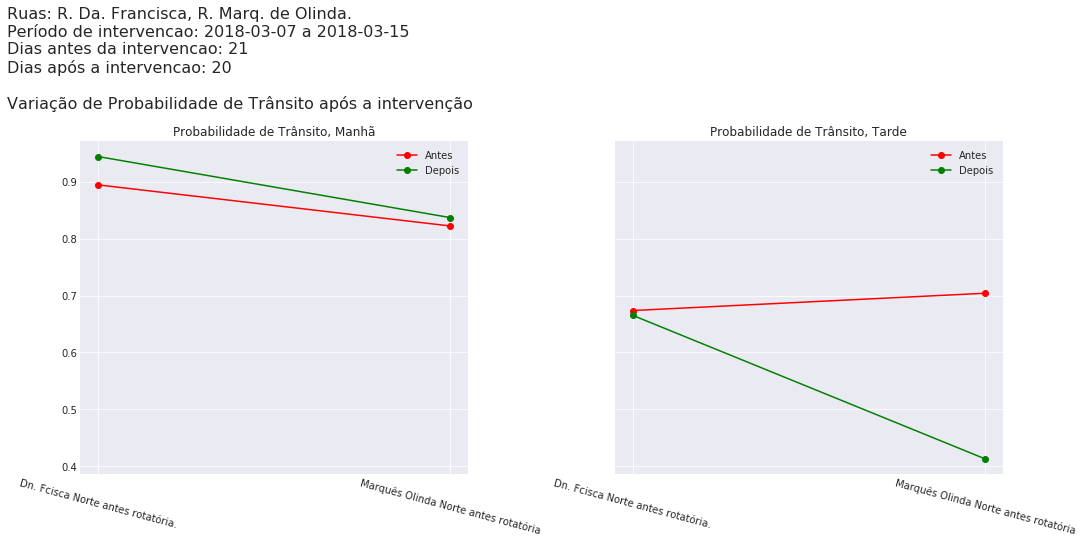

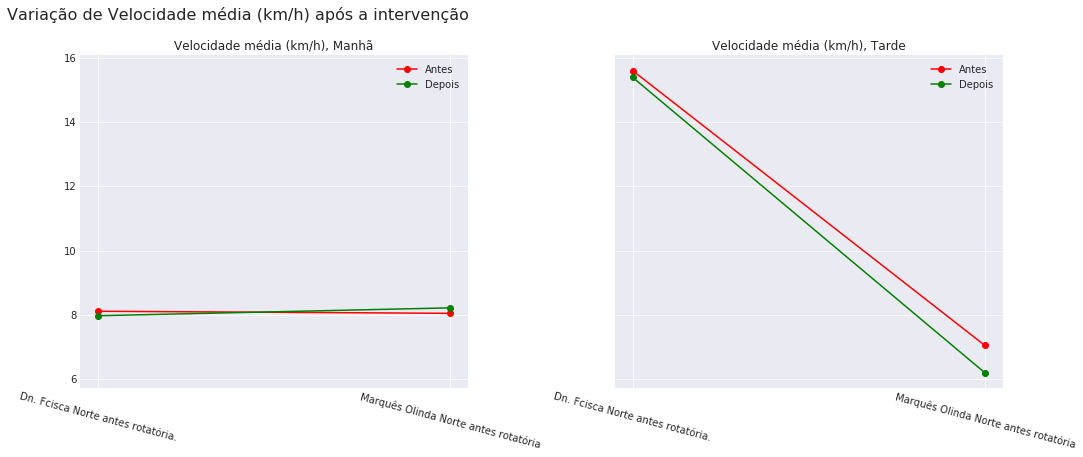

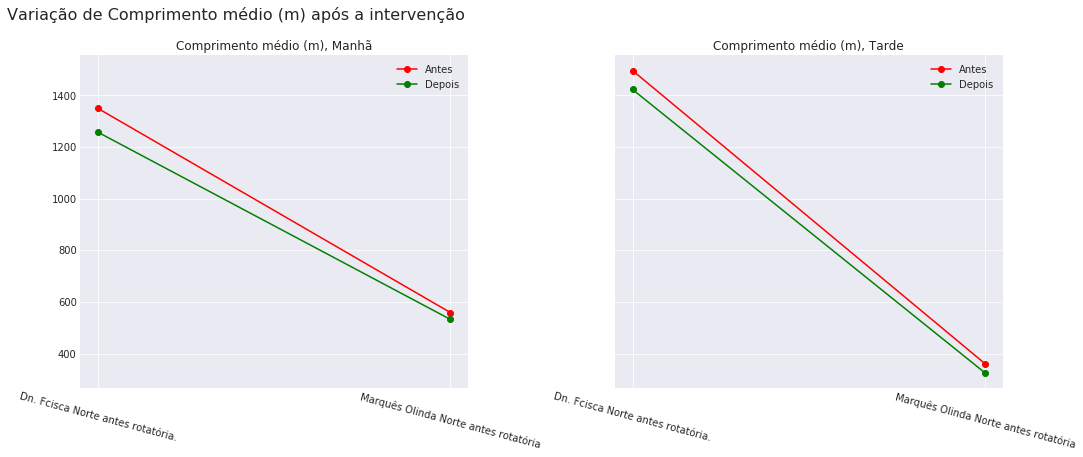

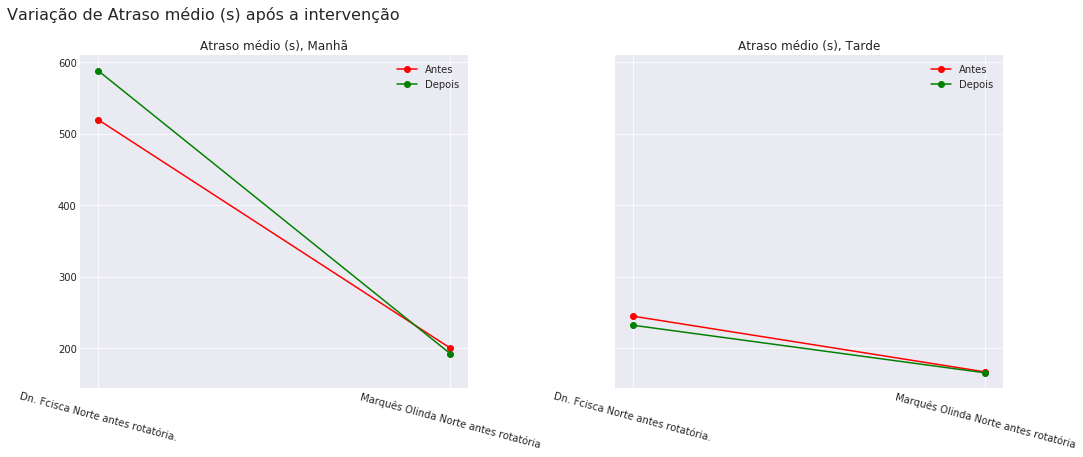

In [7]:
days_before = abs((intervention_date_begin - df_jams.start_time.min().date()).days)
days_after = abs((df_jams.start_time.max().date() - intervention_date_end).days)

#Build chart

bar_width = 0.35
opacity = 0.35
index = traffic_prob.index.get_level_values("pre_post").unique().tolist()
directions = traffic_prob.index.get_level_values("direction_of_interest").unique().tolist()
streets = traffic_prob.street.unique().tolist()
kpi_names = {"traffic_prob": "Probabilidade de Trânsito",
             "wavg_speed_kmh": "Velocidade média (km/h)",
             "wavg_length_jams": "Comprimento médio (m)",
             "wavg_delay": "Atraso médio (s)",
            }
kpi_cols = list(kpi_names.keys())
kpi_labels = list(kpi_names.values())

plt.clf()

for i in range(0, len(kpi_cols)):
    f, axs = plt.subplots(1, 2, sharey=True)
    f.set_figheight(6)
    f.set_figwidth(15)
    
    if i == 0:
        suptitle = "\n".join([
                            "Ruas: " + ", ".join(streets) + ".",
                            "Período de intervencao: " + str(intervention_date_begin) + " a " + str(intervention_date_end),
                            "Dias antes da intervencao: " + str(days_before),
                            "Dias após a intervencao: " + str(days_after),
                            "",            
                            "Variação de %s após a intervenção" % (kpi_names[kpi_cols[i]]),
                           ])
        y_pad=1.25
    else:
        suptitle = "Variação de %s após a intervenção" % (kpi_names[kpi_cols[i]])
        y_pad=1.05
                
    #SUPTITLE
    plt.suptitle(suptitle, fontsize=16, horizontalalignment='left', x=0, y=y_pad)
    
    #MORNING
    data_before = traffic_prob.xs(["Antes", "Manha"], level=["pre_post", "periodo"]).reset_index()
    axs[0].plot(data_before.desc.values, data_before[kpi_cols[i]].values, marker='o', color='red', label="Antes")
    
#     data_during = traffic_prob.xs(["Durante", "Manha"], level=["pre_post", "periodo"]).reset_index()
#     axs[0].plot(data_during.desc.values, data_during[kpi_cols[i]].values, marker='o', color='yellow', label="Durante")
    
    data_after = traffic_prob.xs(["Depois", "Manha"], level=["pre_post", "periodo"]).reset_index()
    axs[0].plot(data_after.desc.values, data_after[kpi_cols[i]].values, marker='o', color='green', label="Depois")
    axs[0].set_title(kpi_labels[i] + ', Manhã')
    axs[0].legend()
    
    #AFTERNOON
    data_before = traffic_prob.xs(["Antes", "Tarde"], level=["pre_post", "periodo"]).reset_index()
    axs[1].plot(data_before.desc.values, data_before[kpi_cols[i]].values, marker='o', color='red', label="Antes")
    
#     data_during = traffic_prob.xs(["Durante", "Tarde"], level=["pre_post", "periodo"]).reset_index()
#     axs[1].plot(data_during.desc.values, data_during[kpi_cols[i]].values, marker='o', color='yellow', label="Durante")
    
    data_after = traffic_prob.xs(["Depois", "Tarde"], level=["pre_post", "periodo"]).reset_index()
    axs[1].plot(data_after.desc.values, data_after[kpi_cols[i]].values, marker='o', color='green', label="Depois")
    axs[1].set_title(kpi_labels[i] + ', Tarde')
    axs[1].legend()
    
    #Save to S3
    for ax in f.axes:
        plt.sca(ax)
        plt.xticks(rotation=-15)
        plt.tight_layout()
    file_name = folder_name + nome_arquivos + "%s.png" % (kpi_cols[i])
    buf = io.BytesIO()
    f.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    s3.put_object(Body=buf, Bucket='smartmob-data', ContentType='image/png', Key=file_name)
    
plt.show()